In [1]:
import pandas as pd
import pickle
from PIL import Image
import numpy as np
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import shelve
import math
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import pickle5 as pickle
import scipy.io
from scipy.stats import sem
import dataframe_image as dfi

In [2]:
##dataloader
from torch.utils.data import Dataset, DataLoader

class FaceDataset(Dataset):
    def __init__(self, txt_path, img_dir, transforms = None):
        df = pickle.load(open(txt_path, "rb"))
        df['img'] = df['img'].str.replace("/mmfs1/data/schwarex/neuralNetworks/identity/datasets/img_align_celeba",
                                          img_dir)
        self.txt_path = txt_path
        self.y = df['new_label']
        self.x = df['img']
        self.n_samples = len(df)
        self.transforms = transforms

        self.mu = torch.randn(1503)
        m = torch.distributions.gamma.Gamma(torch.ones(1503), torch.ones(1503) * 20)
        self.sigma = m.sample()

    def __len__(self):
        return self.n_samples


    def __getitem__(self, index):
        image = Image.open(self.x[index]).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        label = self.y[index]
        base_reward = torch.randn(1)
        reward = base_reward * self.sigma[label] + self.mu[label]
        data = [image, label, reward]

        return data

    
transform = transforms.Compose([transforms.CenterCrop(178),  #original image size = (178, 218)
                                transforms.Resize(128),
                                transforms.ToTensor()])       
                                                                                                                                                     
train_dataset = FaceDataset(txt_path = '/data/zhouabx/celebA/train_SUBSET.pkl',
                            img_dir = '/mmfs1/data/zhouabx/celebA/img_align_celeba/',
                            transforms = transform)

trainloader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

In [3]:
class NetDense(nn.Module):
    def __init__(self, k):
        super(NetDense, self).__init__()
        self.k = k
        #(128, 128, 3)
        self.bn1 = nn.BatchNorm2d(3) #,track_running_stats=False)
        self.encConv1 = nn.Conv2d(3, k, kernel_size = 4, stride = 2, padding = 1) # -> 16 x 64 x 64
        self.bn2 = nn.BatchNorm2d(k)
         
        # first dense block
        self.encConv2 = nn.Conv2d(k, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn3 = nn.BatchNorm2d(k * 2)
        self.encConv3 = nn.Conv2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn4 = nn.BatchNorm2d(k * 3)
        self.encConv4 = nn.Conv2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn5 = nn.BatchNorm2d(k)

        # second dense block
        self.encConv5 = nn.Conv2d(k, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn6 = nn.BatchNorm2d(k * 2)
        self.encConv6 = nn.Conv2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn7 = nn.BatchNorm2d(k * 3)
        self.encConv7 = nn.Conv2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn8 = nn.BatchNorm2d(k)
        
        # third dense block
        self.encConv8 = nn.Conv2d(k, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn9 = nn.BatchNorm2d(k * 2)
        self.encConv9 = nn.Conv2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn10 = nn.BatchNorm2d(k * 3)
        self.encConv10 = nn.Conv2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn11 = nn.BatchNorm2d(k)       
               
        # fully connected part
        self.encoder_mu = nn.Linear(k * 32 * 32, 2048)  
        self.encoder_logVar = nn.Linear (k * 32 * 32, 2048)   
        
        
        ## classifier with reduced layer
        self.classifier = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1503) #1503 ids
        )        
                                              

    def encoder(self, x):
        # first dense block
        x1 = F.relu(self.encConv1(self.bn1(x)))
        x2 = F.relu(self.encConv2(self.bn2(x1)))       
        x = torch.cat((x1, x2), 1) 
        
        x3 = F.relu(self.encConv3(self.bn3(x)))
        x = torch.cat((x1, x2, x3), 1)
        
        x4 = F.relu(self.encConv4(self.bn4(x)))
        x4 = F.avg_pool2d(x4, 2)
        
        # second dense block
        x5 = F.relu(self.encConv5(self.bn5(x4)))
        x = torch.cat((x4, x5), 1)
        x6 = F.relu(self.encConv6(self.bn6(x)))
        x = torch.cat((x4, x5, x6), 1)
        
        x7 = F.relu(self.encConv7(self.bn7(x)))         
        #x7 = F.avg_pool2d(x7, 2)  
       
        # third dense block
        x8 = F.relu(self.encConv8(self.bn8(x7)))
        x = torch.cat((x7, x8), 1)
        x9 = F.relu(self.encConv9(self.bn9(x)))
        x = torch.cat((x7, x8, x9), 1)
        
        x10 = F.relu(self.encConv10(self.bn10(x)))         
        #x10 = F.avg_pool2d(x10, 2)        
                    
        x = self.bn11(x10)
                
        x = x.view(-1, self.k * 32 * 32)
        return self.encoder_mu(x), self.encoder_logVar(x)       
    
    
    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5 * logVar) #logVar = log(sigma^2) -> 0.5*logVar.exp = sigma
        eps = torch.randn_like(std)
        # reparametrisation trick
        return mu + std * eps
 
    
    def classify(self, z):
        return self.classifier(z)

    def forward(self, x):  # encoder -> reparameterization -> decoder
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        classification = self.classifier(z)
        #reconstruction = self.decoder(z)
        return classification, mu, logVar

netDense = NetDense(64) #k = 64
netDense.cuda()  

NetDense(
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv4): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encConv6): Conv2d(128, 64, kernel_size=(3, 3), str

In [4]:
checkpoint = torch.load('/mmfs1/data/zhouabx/KDEF/KDEF_RDM_new/VAE_classification/CelebA_train_results/only_classification.ckp',
                        map_location = 'cpu')
netDense.load_state_dict(checkpoint['netDense_state_dict'])

<All keys matched successfully>

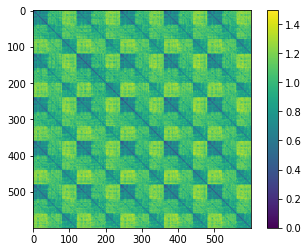

In [7]:
#test on KDEF dataset subset A (note that this is described as dataset B in the paper, and vice versa the dataset that is described as dataset A in the paper is named dataset B in the code)
#open subset_A
Dataset_A = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_A_with_id_expression_direction.pkl', "rb"))

KDEF_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor()])

mu_list_A = []
netDense.eval()
with torch.no_grad():
    for idx, row in Dataset_A.iterrows():
        image = Image.open(Dataset_A['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        classification, mu, logVar = netDense(image[None, :].cuda())
        mu_list_A.append(mu[0, :])
A_mus = torch.stack((mu_list_A))

#save mu
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/SUP/KDEF_test_results_AB/"
with open(path + 'mu_values_A.pkl', 'wb') as pickle_out:
     pickle.dump(A_mus, pickle_out)      
    
Dataset_A['mu_A'] = A_mus.cpu().detach()
Dataset_A_with_mu = Dataset_A  

#average the L and R         
Dataset_A_with_mu["new_direction"] = np.where((Dataset_A_with_mu["direction"].values == "HR") | (Dataset_A_with_mu["direction"] == "HL"), 
         "H", 
         np.where((Dataset_A_with_mu["direction"].values == "FR") | (Dataset_A_with_mu["direction"] == "FL"), 
         "F", 
         Dataset_A_with_mu["direction"].values))        
         

group_index = Dataset_A_with_mu.agg('{0[expression]} and {0[new_direction]} and {0[id]}'.format, axis = 1)

ids = np.unique(group_index)
g_mean = np.array([np.mean(A_mus.cpu().detach().numpy()[group_index == i, 0:], axis = 0) for i in ids])

df_LR_ave = pd.DataFrame(data = np.array(list(map(lambda x : np.str.split(x, sep = " and "), ids))))
df_LR_ave.columns = ["expression", "direction", "id"]
df_LR_ave['mu_A'] = g_mean.tolist()
                
#label everything
dictionary_emotion_A = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
df_LR_ave['emotionlabel_A'] = df_LR_ave['expression'].map(dictionary_emotion_A)

dictionary_view_A = {'F' : 0, 'H' : 1, 'S' : 2}
df_LR_ave['viewlabel_A'] = df_LR_ave['direction'].map(dictionary_view_A)

dictionary_id_A = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AF06' : 4, 'AF07' : 5, 'AF09' : 6, 'AF13' : 7, 'AF14' : 8, 'AF16' : 9,
 'AF20' : 10, 'AF21' : 11, 'AF22' : 12, 'AF24' : 13, 'AF25': 14, 'AF28' : 15, 'AF29' : 16, 'AF30' : 17, 'AF32' : 18, 
 'AF33' : 19, 'AM01' : 20, 'AM05' : 21, 'AM06' : 22, 'AM08' : 23, 'AM09' : 24, 'AM10' : 25, 'AM11' : 26, 'AM13' : 27,
 'AM14' : 28, 'AM15' : 29, 'AM16' : 30, 'AM22' : 31, 'AM23' : 32, 'AM24' : 33, 'AM25' : 34, 'AM28' : 35, 'AM29' : 36,
 'AM30' : 37, 'AM31' : 38, 'AM35' : 39}
df_LR_ave['idlabel_A'] = df_LR_ave['id'].map(dictionary_id_A)

#order everything
New_Data_A = df_LR_ave.sort_values(by = ['emotionlabel_A', 'viewlabel_A', 'idlabel_A'])
#reset the index and save the dataframe in New_Data_A_with_mu
New_Data_A_with_mu = New_Data_A.reset_index(drop = True)  

# create array features
array_features_A = [New_Data_A_with_mu['mu_A'][0]]
for i in range(1, New_Data_A_with_mu.shape[0]):
    array_features_A = np.concatenate((array_features_A, [New_Data_A_with_mu['mu_A'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_A, axis = 0)
centered_data = array_features_A - average_vector

# attach centered_feature
New_Data_A_with_mu['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]

l_A = [None] * 600
for _ in range (len(New_Data_A_with_mu)):
    l_A [New_Data_A_with_mu.iloc[_]['idlabel_A'] + 
         40 * New_Data_A_with_mu.iloc[_]['viewlabel_A'] + 
         40 * 3 * New_Data_A_with_mu.iloc[_]['emotionlabel_A']] = New_Data_A_with_mu.iloc[_]['centered_feature']      

RDM_A = 1 - np.corrcoef(l_A)      

plt.imshow(RDM_A) ## note that this is named RDM B in the paper
plt.colorbar()

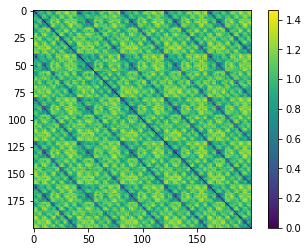

In [8]:
Dataset_B = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_B_with_id_expression_direction.pkl', "rb"))   

KDEF_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor()])

mu_list_B = []
netDense.eval()
with torch.no_grad():
    for idx, row in Dataset_B.iterrows():
        image = Image.open(Dataset_B['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        classification, mu, logVar = netDense(image[None, :].cuda())
        mu_list_B.append(mu[0, :])      
B_mus = torch.stack((mu_list_B))

#save mu
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/SUP/KDEF_test_results_AB/"
with open(path + 'mu_values_B.pkl', 'wb') as pickle_out:
     pickle.dump(B_mus, pickle_out)

#label everything
dictionary_emotion = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
Dataset_B['emotionlabel'] = Dataset_B['expression'].map(dictionary_emotion)

dictionary_view = {'FL' : 0, 'FR' : 1, 'HL' : 2, 'HR' : 3, 'S' : 4}
Dataset_B['viewlabel'] = Dataset_B['direction'].map(dictionary_view)

dictionary_id = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AM08' : 4, 'AM10' : 5, 'AM11' : 6, 'AM25': 7}
Dataset_B['idlabel'] = Dataset_B['id'].map(dictionary_id)

#add mu to the dataset
Dataset_B['mu_B'] = B_mus.cpu().detach()

#order everything
New_Data_B = Dataset_B.sort_values(by = ['emotionlabel', 'viewlabel', 'idlabel'])
#reset the index and save the dataframe in New_Data_B_with_mu
New_Data_B_with_mu = New_Data_B.reset_index(drop = True)

# create array features
array_features_B = [New_Data_B_with_mu['mu_B'][0]]
for i in range(1, New_Data_B_with_mu.shape[0]):
    array_features_B = np.concatenate((array_features_B, [New_Data_B_with_mu['mu_B'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_B, axis = 0)
centered_data = array_features_B - average_vector

# attach centered_feature
New_Data_B_with_mu['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]

# create RDM
l = [None] * 200
for _ in range (len(New_Data_B_with_mu)):
    l [New_Data_B_with_mu.iloc[_]['idlabel'] + 
       8 * New_Data_B_with_mu.iloc[_]['viewlabel'] + 
       8 * 5 * New_Data_B_with_mu.iloc[_]['emotionlabel']] = New_Data_B_with_mu.iloc[_]['centered_feature']

RDM_B = 1 - np.corrcoef(l)

plt.imshow(RDM_B) ## ## note that this is named RDM A in the paper
plt.colorbar()

In [9]:
#save RDM value
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/SUP/KDEF_test_results_AB/"
with open(path + 'RDM_value_A.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_A, pickle_out)
        
with open(path + 'RDM_value_B.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_B, pickle_out)

In [10]:
# open RDMs for KDEF A & B
SUP_RDM_value_A = pickle.load(open('/mmfs1/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/SUP/KDEF_test_results_AB/RDM_value_A.pkl',"rb"))
v_SUP_RDM_A = SUP_RDM_value_A[np.triu_indices(SUP_RDM_value_A.shape[0], 1)]

SUP_RDM_value_B = pickle.load(open('/mmfs1/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/SUP/KDEF_test_results_AB/RDM_value_B.pkl',"rb"))
v_SUP_RDM_B = SUP_RDM_value_B[np.triu_indices(SUP_RDM_value_B.shape[0], 1)]

In [11]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p16/'
vA_p16_rdms = []
v_vA_p16_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p16_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p16_rdms)):
    vector = vA_p16_rdms[i][np.triu_indices(vA_p16_rdms[i].shape[0], 1)]
    v_vA_p16_rdms.append(vector)
    
kendalltau_SUP_and_vA_p16 = []
for i in range (len(v_vA_p16_rdms)):   
    kendalltau_SUP_and_vA_p16.append(stats.kendalltau(v_SUP_RDM_A, v_vA_p16_rdms[i]))
    
corr, _ = kendalltau_SUP_and_vA_p16[0]
print('subset A SUP and p16_e90_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p16[1]
print('subset A SUP and p16_e90_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p16[2]
print('subset A SUP and p16_e90_wind6 kendalltau: %.5f' % corr)

subset A SUP and p16_e90_wind4 kendalltau: 0.04772
subset A SUP and p16_e90_wind5 kendalltau: 0.02721
subset A SUP and p16_e90_wind6 kendalltau: 0.00874


In [13]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p23/'
vA_p23_rdms = []
v_vA_p23_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p23_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p23_rdms)):
    vector = vA_p23_rdms[i][np.triu_indices(vA_p23_rdms[i].shape[0], 1)]
    v_vA_p23_rdms.append(vector)
    
kendalltau_SUP_and_vA_p23 = []
for i in range (len(v_vA_p23_rdms)):   
    kendalltau_SUP_and_vA_p23.append(stats.kendalltau(v_SUP_RDM_A, v_vA_p23_rdms[i]))

corr, _ = kendalltau_SUP_and_vA_p23[0]
print('subset A SUP and p23_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p23[1]
print('subset A SUP and p23_wind5 kendalltau: 0')
corr, _ = kendalltau_SUP_and_vA_p23[2]
print('subset A SUP and p23_wind6 kendalltau: 0')

subset A SUP and p23_wind4 kendalltau: 0.00047
subset A SUP and p23_wind5 kendalltau: 0
subset A SUP and p23_wind6 kendalltau: 0


In [14]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p27/'
vA_p27_rdms = []
v_vA_p27_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p27_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p27_rdms)):
    vector = vA_p27_rdms[i][np.triu_indices(vA_p27_rdms[i].shape[0], 1)]
    v_vA_p27_rdms.append(vector)
    
kendalltau_SUP_and_vA_p27 = []
for i in range (len(v_vA_p27_rdms)):   
    kendalltau_SUP_and_vA_p27.append(stats.kendalltau(v_SUP_RDM_A, v_vA_p27_rdms[i]))

corr, _ = kendalltau_SUP_and_vA_p27[0]
print('subset A SUP and p27_e100_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[1]
print('subset A SUP and p27_e100_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[2]
print('subset A SUP and p27_e100_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[3]
print('subset A SUP and p27_e53_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[4]
print('subset A SUP and p27_e53_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[5]
print('subset A SUP and p27_e53_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[6]
print('subset A SUP and p27_e60_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[7]
print('subset A SUP and p27_e60_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[8]
print('subset A SUP and p27_e60_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[9]
print('subset A SUP and p27_e61_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[10]
print('subset A SUP and p27_e61_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[11]
print('subset A SUP and p27_e61_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[12]
print('subset A SUP and p27_e62_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[13]
print('subset A SUP and p27_e62_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p27[14]
print('subset A SUP and p27_e62_wind6 kendalltau: %.5f' % corr)

subset A SUP and p27_e100_wind4 kendalltau: 0.05333
subset A SUP and p27_e100_wind5 kendalltau: 0.03303
subset A SUP and p27_e100_wind6 kendalltau: 0.00854
subset A SUP and p27_e53_wind4 kendalltau: 0.06170
subset A SUP and p27_e53_wind5 kendalltau: 0.08556
subset A SUP and p27_e53_wind6 kendalltau: 0.04711
subset A SUP and p27_e60_wind4 kendalltau: 0.03000
subset A SUP and p27_e60_wind5 kendalltau: 0.03997
subset A SUP and p27_e60_wind6 kendalltau: 0.00695
subset A SUP and p27_e61_wind4 kendalltau: 0.01536
subset A SUP and p27_e61_wind5 kendalltau: 0.05705
subset A SUP and p27_e61_wind6 kendalltau: 0.02454
subset A SUP and p27_e62_wind4 kendalltau: 0.04406
subset A SUP and p27_e62_wind5 kendalltau: 0.04310
subset A SUP and p27_e62_wind6 kendalltau: 0.03693


In [15]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p28/'
vA_p28_rdms = []
v_vA_p28_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p28_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p28_rdms)):
    vector = vA_p28_rdms[i][np.triu_indices(vA_p28_rdms[i].shape[0], 1)]
    v_vA_p28_rdms.append(vector)
    
kendalltau_SUP_and_vA_p28 = []
for i in range (len(v_vA_p28_rdms)):   
    kendalltau_SUP_and_vA_p28.append(stats.kendalltau(v_SUP_RDM_A, v_vA_p28_rdms[i]))

corr, _ = kendalltau_SUP_and_vA_p28[0]
print('subset A SUP and p28_e85_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p28[1]
print('subset A SUP and p28_e85_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p28[2]
print('subset A SUP and p28_e85_wind6 kendalltau: %.5f' % corr)

subset A SUP and p28_e85_wind4 kendalltau: 0.04131
subset A SUP and p28_e85_wind5 kendalltau: 0.00655
subset A SUP and p28_e85_wind6 kendalltau: 0.00446


In [17]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p30/'
vA_p30_rdms = []
v_vA_p30_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p30_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p30_rdms)):
    vector = vA_p30_rdms[i][np.triu_indices(vA_p30_rdms[i].shape[0], 1)]
    v_vA_p30_rdms.append(vector)
    
kendalltau_SUP_and_vA_p30 = []
for i in range (len(v_vA_p30_rdms)):   
    kendalltau_SUP_and_vA_p30.append(stats.kendalltau(v_SUP_RDM_A, v_vA_p30_rdms[i]))

corr, _ = kendalltau_SUP_and_vA_p30[0]
print('subset A SUP and p30_e8_wind4 kendalltau: 0')
corr, _ = kendalltau_SUP_and_vA_p30[1]
print('subset A SUP and p30_e8_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p30[2]
print('subset A SUP and p30_e8_wind6 kendalltau: 0')

subset A SUP and p30_e8_wind4 kendalltau: 0
subset A SUP and p30_e8_wind5 kendalltau: 0.00053
subset A SUP and p30_e8_wind6 kendalltau: 0


In [19]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p34/'
vA_p34_rdms = []
v_vA_p34_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p34_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p34_rdms)):
    vector = vA_p34_rdms[i][np.triu_indices(vA_p34_rdms[i].shape[0], 1)]
    v_vA_p34_rdms.append(vector)
    
kendalltau_SUP_and_vA_p34 = []
for i in range (len(v_vA_p34_rdms)):   
    kendalltau_SUP_and_vA_p34.append(stats.kendalltau(v_SUP_RDM_A, v_vA_p34_rdms[i]))

corr, _ = kendalltau_SUP_and_vA_p34[0]
print('subset A SUP and p34_e23_wind4 kendalltau: 0')
corr, _ = kendalltau_SUP_and_vA_p34[1]
print('subset A SUP and p34_e23_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p34[2]
print('subset A SUP and p34_e23_wind6 kendalltau: 0')
corr, _ = kendalltau_SUP_and_vA_p34[3]
print('subset A SUP and p34_e42_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p34[4]
print('subset A SUP and p34_e42_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p34[5]
print('subset A SUP and p34_e42_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p34[6]
print('subset A SUP and p34_e44_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p34[7]
print('subset A SUP and p34_e44_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p34[8]
print('subset A SUP and p34_e44_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p34[9]
print('subset A SUP and p43_e43_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p34[10]
print('subset A SUP and p43_e43_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p34[11]
print('subset A SUP and p43_e43_wind6 kendalltau: %.5f' % corr)

subset A SUP and p34_e23_wind4 kendalltau: 0
subset A SUP and p34_e23_wind5 kendalltau: 0.00157
subset A SUP and p34_e23_wind6 kendalltau: 0
subset A SUP and p34_e42_wind4 kendalltau: 0.01819
subset A SUP and p34_e42_wind5 kendalltau: 0.00551
subset A SUP and p34_e42_wind6 kendalltau: 0.00082
subset A SUP and p34_e44_wind4 kendalltau: 0.02710
subset A SUP and p34_e44_wind5 kendalltau: 0.01704
subset A SUP and p34_e44_wind6 kendalltau: 0.00202
subset A SUP and p43_e43_wind4 kendalltau: 0.08086
subset A SUP and p43_e43_wind5 kendalltau: 0.02782
subset A SUP and p43_e43_wind6 kendalltau: 0.00443


In [20]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p36/'
vA_p36_rdms = []
v_vA_p36_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p36_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p36_rdms)):
    vector = vA_p36_rdms[i][np.triu_indices(vA_p36_rdms[i].shape[0], 1)]
    v_vA_p36_rdms.append(vector)
    
kendalltau_SUP_and_vA_p36 = []
for i in range (len(v_vA_p36_rdms)):   
    kendalltau_SUP_and_vA_p36.append(stats.kendalltau(v_SUP_RDM_A, v_vA_p36_rdms[i]))

corr, _ = kendalltau_SUP_and_vA_p36[0]
print('subset A SUP and p36_e64_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p36[1]
print('subset A SUP and p36_e64_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p36[2]
print('subset A SUP and p36_e64_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p36[3]
print('subset A SUP and p36_e69_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p36[4]
print('subset A SUP and p36_e69_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p36[5]
print('subset A SUP and p36_e69_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p36[6]
print('subset A SUP and p36_e70_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p36[7]
print('subset A SUP and p36_e70_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vA_p36[8]
print('subset A SUP and p36_e70_wind6 kendalltau: %.5f' % corr)

subset A SUP and p36_e64_wind4 kendalltau: 0.12221
subset A SUP and p36_e64_wind5 kendalltau: 0.07929
subset A SUP and p36_e64_wind6 kendalltau: 0.04553
subset A SUP and p36_e69_wind4 kendalltau: 0.00492
subset A SUP and p36_e69_wind5 kendalltau: 0.00672
subset A SUP and p36_e69_wind6 kendalltau: 0.00988
subset A SUP and p36_e70_wind4 kendalltau: 0.00274
subset A SUP and p36_e70_wind5 kendalltau: 0.00672
subset A SUP and p36_e70_wind6 kendalltau: 0.00357


In [22]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p39/'
vA_p39_rdms = []
v_vA_p39_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p39_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p39_rdms)):
    vector = vA_p39_rdms[i][np.triu_indices(vA_p39_rdms[i].shape[0], 1)]
    v_vA_p39_rdms.append(vector)
    
kendalltau_SUP_and_vA_p39 = []
for i in range (len(v_vA_p39_rdms)):   
    kendalltau_SUP_and_vA_p39.append(stats.kendalltau(v_SUP_RDM_A, v_vA_p39_rdms[i]))

corr, _ = kendalltau_SUP_and_vA_p39[0]
print('subset A SUP and p39_wind4 kendalltau: 0')
corr, _ = kendalltau_SUP_and_vA_p39[1]
print('subset A SUP and p39_wind5 kendalltau: 0')
corr, _ = kendalltau_SUP_and_vA_p39[2]
print('subset A SUP and p39_wind6 kendalltau: 0')

subset A SUP and p39_wind4 kendalltau: 0
subset A SUP and p39_wind5 kendalltau: 0
subset A SUP and p39_wind6 kendalltau: 0


In [23]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/p41/'
vB_p41_rdms = []
v_vB_p41_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p41_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p41_rdms)):
    vector = vB_p41_rdms[i][np.triu_indices(vB_p41_rdms[i].shape[0], 1)]
    v_vB_p41_rdms.append(vector)
    
kendalltau_SUP_and_vB_p41 = []
for i in range (len(v_vB_p41_rdms)):   
    kendalltau_SUP_and_vB_p41.append(stats.kendalltau(v_SUP_RDM_B, v_vB_p41_rdms[i]))

corr, _ = kendalltau_SUP_and_vB_p41[1]
print('subset B SUP and p41_e10_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[2]
print('subset B SUP and p41_e10_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[3]
print('subset B SUP and p41_e10_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[7]
print('subset B SUP and p41_e11_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[8]
print('subset B SUP and p41_e11_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[9]
print('subset B SUP and p41_e11_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[13]
print('subset B SUP and p41_e12_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[14]
print('subset B SUP and p41_e12_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[15]
print('subset B SUP and p41_e12_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[19]
print('subset B SUP and p41_e2_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[20]
print('subset B SUP and p41_e2_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[21]
print('subset B SUP and p41_e2_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[25]
print('subset B SUP and p41_e24_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[26]
print('subset B SUP and p41_e24_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[27]
print('subset B SUP and p41_e24_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[31]
print('subset B SUP and p41_e9_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[32]
print('subset B SUP and p41_e9_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p41[33]
print('subset B SUP and p41_e9_wind6 kendalltau: %.5f' % corr)

subset B SUP and p41_e10_wind4 kendalltau: 0.27575
subset B SUP and p41_e10_wind5 kendalltau: 0.21374
subset B SUP and p41_e10_wind6 kendalltau: 0.03103
subset B SUP and p41_e11_wind4 kendalltau: 0.17604
subset B SUP and p41_e11_wind5 kendalltau: 0.11470
subset B SUP and p41_e11_wind6 kendalltau: 0.00984
subset B SUP and p41_e12_wind4 kendalltau: 0.08977
subset B SUP and p41_e12_wind5 kendalltau: 0.04539
subset B SUP and p41_e12_wind6 kendalltau: 0.01927
subset B SUP and p41_e2_wind4 kendalltau: 0.15774
subset B SUP and p41_e2_wind5 kendalltau: 0.08305
subset B SUP and p41_e2_wind6 kendalltau: 0.00929
subset B SUP and p41_e24_wind4 kendalltau: 0.10769
subset B SUP and p41_e24_wind5 kendalltau: 0.03302
subset B SUP and p41_e24_wind6 kendalltau: 0.00837
subset B SUP and p41_e9_wind4 kendalltau: 0.20987
subset B SUP and p41_e9_wind5 kendalltau: 0.11719
subset B SUP and p41_e9_wind6 kendalltau: 0.02061


In [24]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/fusiform_reliable/p47/'
vB_p47_rdms = []
v_vB_p47_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p47_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p47_rdms)):
    vector = vB_p47_rdms[i][np.triu_indices(vB_p47_rdms[i].shape[0], 1)]
    v_vB_p47_rdms.append(vector)

kendalltau_SUP_and_vB_p47 = []
for i in range (len(v_vB_p47_rdms)):   
    kendalltau_SUP_and_vB_p47.append(stats.kendalltau(v_SUP_RDM_B, v_vB_p47_rdms[i]))

corr, _ = kendalltau_SUP_and_vB_p47[1]
print('subset B SUP and p47_e34_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p47[2]
print('subset B SUP and p47_e34_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_SUP_and_vB_p47[3]
print('subset B SUP and p47_e34_wind6 kendalltau: %.5f' % corr)

subset B SUP and p47_e34_wind4 kendalltau: 0.16781
subset B SUP and p47_e34_wind5 kendalltau: 0.08401
subset B SUP and p47_e34_wind6 kendalltau: 0.01793


In [26]:
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/SUP/KDEF_test_results_AB/kendalltaus/"

SUP_tau_wind4 = np.array([kendalltau_SUP_and_vA_p16[0][0],
                            kendalltau_SUP_and_vA_p23[0][0],
                            kendalltau_SUP_and_vA_p27[0][0],
                            kendalltau_SUP_and_vA_p27[3][0],
                            kendalltau_SUP_and_vA_p27[6][0],
                            kendalltau_SUP_and_vA_p27[9][0],
                            kendalltau_SUP_and_vA_p27[12][0],
                            kendalltau_SUP_and_vA_p28[0][0],
                            0,
                            0,
                            kendalltau_SUP_and_vA_p34[3][0],
                            kendalltau_SUP_and_vA_p34[6][0],
                            kendalltau_SUP_and_vA_p34[9][0],
                            kendalltau_SUP_and_vA_p36[0][0],
                            kendalltau_SUP_and_vA_p36[3][0],
                            kendalltau_SUP_and_vA_p36[6][0],
                            0,
                            kendalltau_SUP_and_vB_p41[1][0],
                            kendalltau_SUP_and_vB_p41[7][0],
                            kendalltau_SUP_and_vB_p41[13][0],
                            kendalltau_SUP_and_vB_p41[19][0],
                            kendalltau_SUP_and_vB_p41[25][0],
                            kendalltau_SUP_and_vB_p41[31][0],
                            kendalltau_SUP_and_vB_p47[1][0]])

SUP_tau_wind4_mean = np.mean(SUP_tau_wind4)
SUP_tau_wind4_sem = sem(SUP_tau_wind4)

with open(path + 'SUP_tau_wind4.pkl', 'wb') as pickle_out:
     pickle.dump(SUP_tau_wind4, pickle_out)      
with open(path + 'SUP_tau_wind4_mean.pkl', 'wb') as pickle_out:
     pickle.dump(SUP_tau_wind4_mean, pickle_out) 
with open(path + 'SUP_tau_wind4_sem.pkl', 'wb') as pickle_out:
     pickle.dump(SUP_tau_wind4_sem, pickle_out) 


SUP_tau_wind5 = np.array([kendalltau_SUP_and_vA_p16[1][0],
                            0,
                            kendalltau_SUP_and_vA_p27[1][0],
                            kendalltau_SUP_and_vA_p27[4][0],
                            kendalltau_SUP_and_vA_p27[7][0],
                            kendalltau_SUP_and_vA_p27[10][0],
                            kendalltau_SUP_and_vA_p27[13][0],
                            kendalltau_SUP_and_vA_p28[1][0],
                            kendalltau_SUP_and_vA_p30[1][0],
                            kendalltau_SUP_and_vA_p34[1][0],
                            kendalltau_SUP_and_vA_p34[4][0],
                            kendalltau_SUP_and_vA_p34[7][0],
                            kendalltau_SUP_and_vA_p34[10][0],
                            kendalltau_SUP_and_vA_p36[1][0],
                            kendalltau_SUP_and_vA_p36[4][0],
                            kendalltau_SUP_and_vA_p36[7][0],
                            0,
                            kendalltau_SUP_and_vB_p41[2][0],
                            kendalltau_SUP_and_vB_p41[8][0],
                            kendalltau_SUP_and_vB_p41[14][0],
                            kendalltau_SUP_and_vB_p41[20][0],
                            kendalltau_SUP_and_vB_p41[26][0],
                            kendalltau_SUP_and_vB_p41[32][0],
                            kendalltau_SUP_and_vB_p47[2][0]])

SUP_tau_wind5_mean = np.mean(SUP_tau_wind5)
SUP_tau_wind5_sem = sem(SUP_tau_wind5)

with open(path + 'SUP_tau_wind5.pkl', 'wb') as pickle_out:
     pickle.dump(SUP_tau_wind5, pickle_out)      
with open(path + 'SUP_tau_wind5_mean.pkl', 'wb') as pickle_out:
     pickle.dump(SUP_tau_wind5_mean, pickle_out) 
with open(path + 'SUP_tau_wind5_sem.pkl', 'wb') as pickle_out:
     pickle.dump(SUP_tau_wind5_sem, pickle_out) 


SUP_tau_wind6 = np.array([kendalltau_SUP_and_vA_p16[2][0],
                            0,
                            kendalltau_SUP_and_vA_p27[2][0],
                            kendalltau_SUP_and_vA_p27[5][0],
                            kendalltau_SUP_and_vA_p27[8][0],
                            kendalltau_SUP_and_vA_p27[11][0],
                            kendalltau_SUP_and_vA_p27[14][0],
                            kendalltau_SUP_and_vA_p28[2][0],
                            0,
                            0,
                            kendalltau_SUP_and_vA_p34[5][0],
                            kendalltau_SUP_and_vA_p34[8][0],
                            kendalltau_SUP_and_vA_p34[11][0],
                            kendalltau_SUP_and_vA_p36[2][0],
                            kendalltau_SUP_and_vA_p36[5][0],
                            kendalltau_SUP_and_vA_p36[8][0],
                            0,
                            kendalltau_SUP_and_vB_p41[3][0],
                            kendalltau_SUP_and_vB_p41[9][0],
                            kendalltau_SUP_and_vB_p41[15][0],
                            kendalltau_SUP_and_vB_p41[21][0],
                            kendalltau_SUP_and_vB_p41[27][0],
                            kendalltau_SUP_and_vB_p41[33][0],
                            kendalltau_SUP_and_vB_p47[3][0]])

SUP_tau_wind6_mean = np.mean(SUP_tau_wind6)
SUP_tau_wind6_sem = sem(SUP_tau_wind6)

with open(path + 'SUP_tau_wind6.pkl', 'wb') as pickle_out:
     pickle.dump(SUP_tau_wind6, pickle_out)      
with open(path + 'SUP_tau_wind6_mean.pkl', 'wb') as pickle_out:
     pickle.dump(SUP_tau_wind6_mean, pickle_out) 
with open(path + 'SUP_tau_wind6_sem.pkl', 'wb') as pickle_out:
     pickle.dump(SUP_tau_wind6_sem, pickle_out) 

In [30]:
d_SUP_win_4 = {'value': [kendalltau_SUP_and_vA_p16[0][0],
                            kendalltau_SUP_and_vA_p23[0][0],
                            kendalltau_SUP_and_vA_p27[0][0],
                            kendalltau_SUP_and_vA_p27[3][0],
                            kendalltau_SUP_and_vA_p27[6][0],
                            kendalltau_SUP_and_vA_p27[9][0],
                            kendalltau_SUP_and_vA_p27[12][0],
                            kendalltau_SUP_and_vA_p28[0][0],
                            0,
                            0,
                            kendalltau_SUP_and_vA_p34[3][0],
                            kendalltau_SUP_and_vA_p34[6][0],
                            kendalltau_SUP_and_vA_p34[9][0],
                            kendalltau_SUP_and_vA_p36[0][0],
                            kendalltau_SUP_and_vA_p36[3][0],
                            kendalltau_SUP_and_vA_p36[6][0],
                            0,
                            kendalltau_SUP_and_vB_p41[1][0],
                            kendalltau_SUP_and_vB_p41[7][0],
                            kendalltau_SUP_and_vB_p41[13][0],
                            kendalltau_SUP_and_vB_p41[19][0],
                            kendalltau_SUP_and_vB_p41[25][0],
                            kendalltau_SUP_and_vB_p41[31][0],
                            kendalltau_SUP_and_vB_p47[1][0]], 
     'window': ['window4'] * len(SUP_tau_wind4), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['SUP'] * len(SUP_tau_wind4)}
SUP_win_4 = pd.DataFrame(data = d_SUP_win_4)

d_SUP_win_5 = {'value': [kendalltau_SUP_and_vA_p16[1][0],
                            0,
                            kendalltau_SUP_and_vA_p27[1][0],
                            kendalltau_SUP_and_vA_p27[4][0],
                            kendalltau_SUP_and_vA_p27[7][0],
                            kendalltau_SUP_and_vA_p27[10][0],
                            kendalltau_SUP_and_vA_p27[13][0],
                            kendalltau_SUP_and_vA_p28[1][0],
                            kendalltau_SUP_and_vA_p30[1][0],
                            kendalltau_SUP_and_vA_p34[1][0],
                            kendalltau_SUP_and_vA_p34[4][0],
                            kendalltau_SUP_and_vA_p34[7][0],
                            kendalltau_SUP_and_vA_p34[10][0],
                            kendalltau_SUP_and_vA_p36[1][0],
                            kendalltau_SUP_and_vA_p36[4][0],
                            kendalltau_SUP_and_vA_p36[7][0],
                            0,
                            kendalltau_SUP_and_vB_p41[2][0],
                            kendalltau_SUP_and_vB_p41[8][0],
                            kendalltau_SUP_and_vB_p41[14][0],
                            kendalltau_SUP_and_vB_p41[20][0],
                            kendalltau_SUP_and_vB_p41[26][0],
                            kendalltau_SUP_and_vB_p41[32][0],
                            kendalltau_SUP_and_vB_p47[2][0]], 
     'window': ['window5'] * len(SUP_tau_wind5), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['SUP'] * len(SUP_tau_wind5)}
SUP_win_5 = pd.DataFrame(data = d_SUP_win_5)

d_SUP_win_6 = {'value': [kendalltau_SUP_and_vA_p16[2][0],
                            0,
                            kendalltau_SUP_and_vA_p27[2][0],
                            kendalltau_SUP_and_vA_p27[5][0],
                            kendalltau_SUP_and_vA_p27[8][0],
                            kendalltau_SUP_and_vA_p27[11][0],
                            kendalltau_SUP_and_vA_p27[14][0],
                            kendalltau_SUP_and_vA_p28[2][0],
                            0,
                            0,
                            kendalltau_SUP_and_vA_p34[5][0],
                            kendalltau_SUP_and_vA_p34[8][0],
                            kendalltau_SUP_and_vA_p34[11][0],
                            kendalltau_SUP_and_vA_p36[2][0],
                            kendalltau_SUP_and_vA_p36[5][0],
                            kendalltau_SUP_and_vA_p36[8][0],
                            0,
                            kendalltau_SUP_and_vB_p41[3][0],
                            kendalltau_SUP_and_vB_p41[9][0],
                            kendalltau_SUP_and_vB_p41[15][0],
                            kendalltau_SUP_and_vB_p41[21][0],
                            kendalltau_SUP_and_vB_p41[27][0],
                            kendalltau_SUP_and_vB_p41[33][0],
                            kendalltau_SUP_and_vB_p47[3][0]], 
     'window': ['window6'] * len(SUP_tau_wind6), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['SUP'] * len(SUP_tau_wind6)}
SUP_win_6 = pd.DataFrame(data = d_SUP_win_6)

SUP = pd.concat([SUP_win_4, SUP_win_5, SUP_win_6])
SUP

,value,window,subject,model
0,0.047717,window4,16,SUP
1,0.000465,window4,23,SUP
2,0.053333,window4,27,SUP
3,0.061703,window4,27,SUP
4,0.029997,window4,27,SUP
...,...,...,...,...
19,0.019274,window6,41,SUP
20,0.009287,window6,41,SUP
21,0.008367,window6,41,SUP
22,0.020606,window6,41,SUP


In [31]:
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/SUP/SUP_ttest_df/"
with open(path + 'SUP.pkl', 'wb') as pickle_out:
     pickle.dump(SUP, pickle_out)      